Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_10 (Conv2D)          (None, 31, 31, 16)           448       ['input_5[0][0]']             
                                                                                                  
 conv2d_11 (Conv2D)          (None, 15, 15, 32)           4640      ['conv2d_10[0][0]']           
                                                                                                  
 flatten_4 (Flatten)         (None, 7200)                 0         ['conv2d_11[0][0]']           
                                                                                            

2025-05-26 20:37:47.551528: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 49152000 exceeds 10% of free system memory.


32/32 [==============================] - 1s 12ms/step - loss: 0.2081 - class_output_loss: 0.1563 - bbox_output_loss: 0.0519
Epoch 2/2
32/32 [==============================] - 0s 9ms/step - loss: 0.0057 - class_output_loss: 3.4995e-04 - bbox_output_loss: 0.0053


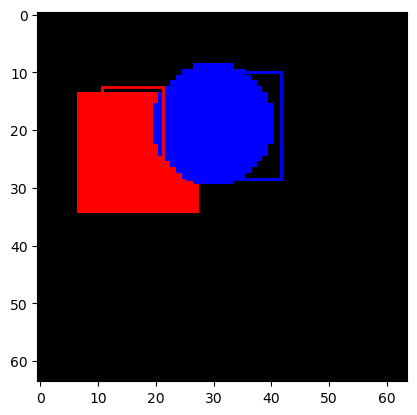

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import random

IMG_SIZE = 64
NUM_CLASSES = 2  # red square, blue circle

# ==== DATA GENERATION ====
def generate_sample():
    img = Image.new("RGB", (IMG_SIZE, IMG_SIZE), "black")
    draw = ImageDraw.Draw(img)

    labels = np.zeros(NUM_CLASSES)
    bboxes = np.zeros((NUM_CLASSES, 4))  # x1, y1, x2, y2

    for cls in range(NUM_CLASSES):
        x1, y1 = random.randint(5, 30), random.randint(5, 30)
        x2, y2 = x1 + 20, y1 + 20

        if cls == 0: draw.rectangle([x1, y1, x2, y2], fill="red")
        if cls == 1: draw.ellipse([x1, y1, x2, y2], fill="blue")

        labels[cls] = 1
        bboxes[cls] = np.array([x1, y1, x2, y2]) / IMG_SIZE  # normalize

    img_array = np.array(img) / 255.0
    return img_array, labels, bboxes

def create_dataset(num_samples=1000):
    X, y_cls, y_bbox = [], [], []
    for _ in range(num_samples):
        img, labels, bboxes = generate_sample()
        X.append(img)
        y_cls.append(labels)
        y_bbox.append(bboxes)
    return np.array(X), np.array(y_cls), np.array(y_bbox)

X_train, y_train_cls, y_train_bbox = create_dataset()

# ==== MODEL ====
input_layer = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.layers.Conv2D(16, 3, strides=2, activation='relu')(input_layer)
x = tf.keras.layers.Conv2D(32, 3, strides=2, activation='relu')(x)
x = tf.keras.layers.Flatten()(x)

class_out = tf.keras.layers.Dense(NUM_CLASSES, activation='sigmoid', name="class_output")(x)
bbox_out = tf.keras.layers.Dense(NUM_CLASSES * 4)(x)
bbox_out = tf.keras.layers.Reshape((NUM_CLASSES, 4), name="bbox_output")(bbox_out)

model = tf.keras.Model(inputs=input_layer, outputs=[class_out, bbox_out])



model.compile(
    optimizer='adam',
    loss={'class_output': 'binary_crossentropy', 'bbox_output': 'mse'},
    loss_weights={'class_output': 1.0, 'bbox_output': 1.0}
)

model.summary()

# ==== TRAIN ====
model.fit(
    X_train, {'class_output': y_train_cls, 'bbox_output': y_train_bbox},
    epochs=2, batch_size=32
)

# ==== INFERENCE EXAMPLE ====
def show_prediction(model, X, idx=0):
    img = X[idx]
    pred_cls, pred_bbox = model.predict(np.expand_dims(img, 0), verbose=0)
    pred_cls, pred_bbox = pred_cls[0], pred_bbox[0]

    fig, ax = plt.subplots()
    ax.imshow(img)
    colors = ['r', 'b']
    for i in range(NUM_CLASSES):
        if pred_cls[i] > 0.5:
            x1, y1, x2, y2 = pred_bbox[i] * IMG_SIZE
            rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor=colors[i], fill=False, linewidth=2)
            ax.add_patch(rect)
    plt.show()

show_prediction(model, X_train)


In [11]:
def show_prediction(model, X, idx=0):
    img = X[idx]
    pred_cls, pred_bbox = model.predict(np.expand_dims(img, 0), verbose=0)
    pred_cls, pred_bbox = pred_cls[0], pred_bbox[0]

    fig, ax = plt.subplots()
    ax.imshow(img)

    class_names = ["Red Square", "Blue Circle"]
    colors = ['violet', 'green']

    for i in range(NUM_CLASSES):
        confidence = pred_cls[i]
        if confidence > 0.5:
            x1, y1, x2, y2 = pred_bbox[i] * IMG_SIZE
            width, height = x2 - x1, y2 - y1
            rect = plt.Rectangle((x1, y1), width, height,
                                 edgecolor=colors[i], facecolor='none', linewidth=2)
            ax.add_patch(rect)
            ax.text(x1, y1 - 2, f"{class_names[i]} ({confidence:.2f})",
                    color=colors[i], fontsize=8, backgroundcolor='black')
    plt.axis('off')
    plt.show()


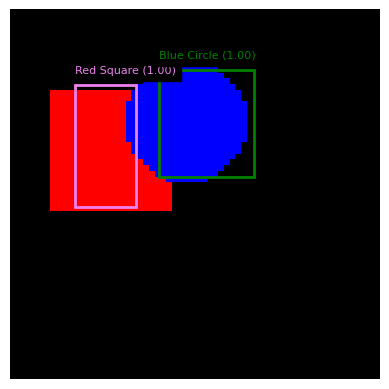

In [12]:
show_prediction(model, X_train)

In [14]:
test

NameError: name 'test' is not defined

Visualizing sample images...


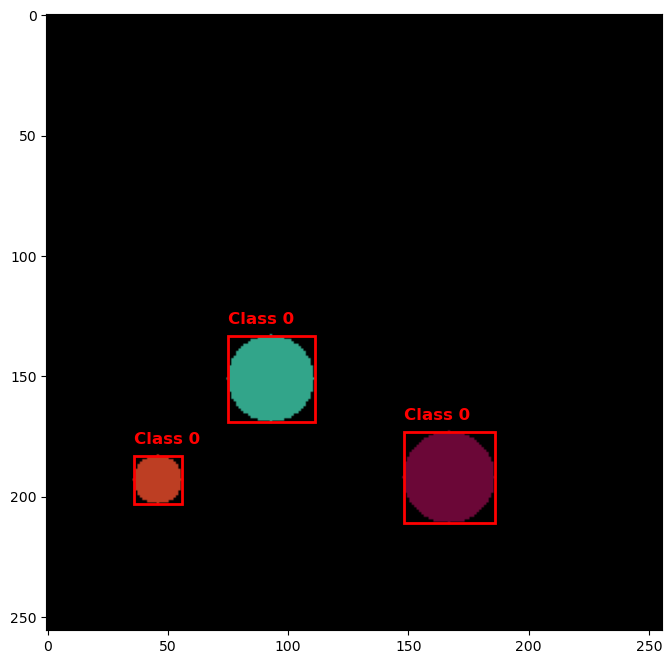

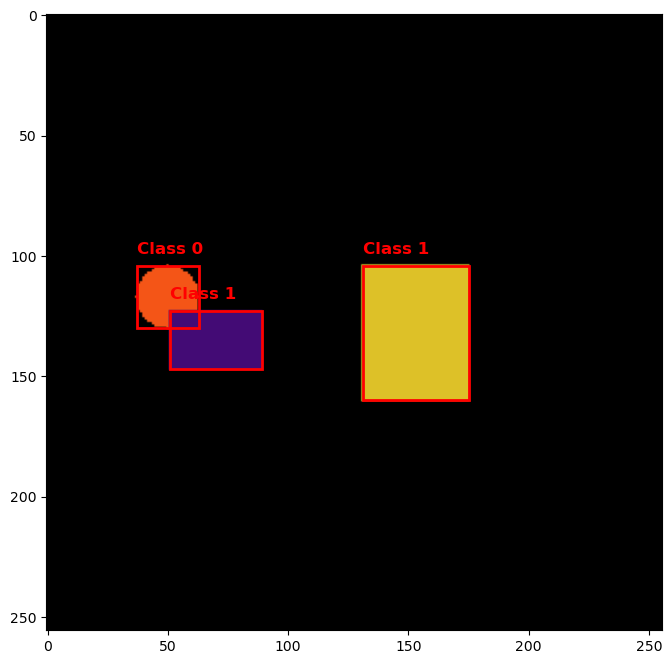

/home/marcos/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/marcos/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training...


KeyboardInterrupt: 

In [13]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import random

import cv2

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

## Synthetic Dataset Creation
class SyntheticObjectDataset(Dataset):
    def __init__(self, num_samples=1000, image_size=256, transform=None):
        """
        Creates synthetic images with two types of objects (circles and rectangles)
        Each image contains 1-3 objects randomly placed
        
        Args:
            num_samples: Number of synthetic images to generate
            image_size: Size of the square images (width=height)
            transform: Optional torchvision transforms to apply
        """
        self.num_samples = num_samples
        self.image_size = image_size
        self.transform = transform
        self.classes = ['circle', 'rectangle']
        
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        # Create blank image
        image = np.zeros((self.image_size, self.image_size, 3), dtype=np.float32)
        
        # Initialize targets
        boxes = []
        labels = []
        
        # Random number of objects (1-3)
        num_objects = random.randint(1, 3)
        
        for _ in range(num_objects):
            # Randomly choose object type
            obj_type = random.choice(self.classes)
            label = self.classes.index(obj_type)
            
            # Random size and color
            size = random.randint(20, 50)
            color = (random.random(), random.random(), random.random())
            
            # Random position (ensure it stays within bounds)
            x = random.randint(size, self.image_size - size)
            y = random.randint(size, self.image_size - size)
            
            # Draw the object
            if obj_type == 'circle':
                # Create circle
                center = (x, y)
                radius = size // 2
                cv2.circle(image, center, radius, color, -1)
                
                # Bounding box coordinates (xmin, ymin, xmax, ymax)
                box = [x - radius, y - radius, x + radius, y + radius]
                
            else:  # rectangle
                # Random width/height ratio
                w = size
                h = random.randint(size//2, size*2)
                
                # Create rectangle
                top_left = (x - w//2, y - h//2)
                bottom_right = (x + w//2, y + h//2)
                cv2.rectangle(image, top_left, bottom_right, color, -1)
                
                # Bounding box coordinates
                box = [x - w//2, y - h//2, x + w//2, y + h//2]
            
            boxes.append(box)
            labels.append(label)
        
        # Convert to tensor and normalize
        image = transforms.ToTensor()(image)
        
        # Convert boxes and labels to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        # Target dictionary expected by torchvision detection models
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        if self.transform:
            image = self.transform(image)
            
        return image, target

# Example visualization function
def plot_image_with_boxes(image, target):
    """
    Plots image with bounding boxes and class labels
    """
    image = image.permute(1, 2, 0).numpy()
    
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)
    
    for box, label in zip(target["boxes"], target["labels"]):
        xmin, ymin, xmax, ymax = box
        width = xmax - xmin
        height = ymax - ymin
        
        rect = patches.Rectangle(
            (xmin, ymin), width, height,
            linewidth=2, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
        
        ax.text(
            xmin, ymin - 5, f"Class {label}",
            color='red', fontsize=12, weight='bold'
        )
    
    plt.show()

## Model Definition
def create_detection_model(num_classes):
    """
    Creates a Faster R-CNN model for object detection
    
    Args:
        num_classes: Number of classes (including background)
    
    Returns:
        PyTorch detection model
    """
    # Load a pre-trained model for transfer learning
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # Get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
        in_features, num_classes
    )
    
    return model

## Training Setup
def collate_fn(batch):
    """
    Custom collate function to handle variable numbers of objects per image
    """
    return tuple(zip(*batch))

def train_model(model, dataloader, num_epochs=5):
    """
    Training loop for the detection model
    """
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    
    # Optimizer and learning rate scheduler
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    
    model.train()
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        
        for images, targets in dataloader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            
            epoch_loss += losses.item()
        
        lr_scheduler.step()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(dataloader):.4f}")
    
    return model

## Main Execution
if __name__ == "__main__":
    # Create synthetic dataset
    dataset = SyntheticObjectDataset(num_samples=1000, image_size=256)
    
    # Split into train and test
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn
    )
    test_loader = DataLoader(
        test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn
    )
    
    # Visualize some samples
    print("Visualizing sample images...")
    for i in range(2):
        image, target = dataset[i]
        plot_image_with_boxes(image, target)
    
    # Create model (2 classes + background)
    model = create_detection_model(num_classes=3)  # background is class 0
    
    # Train the model
    print("Starting training...")
    trained_model = train_model(model, train_loader, num_epochs=2)
    
    # Save the model
    torch.save(trained_model.state_dict(), "object_detection_model.pth")
    print("Model saved to object_detection_model.pth")